# Modeling relative strain prevalence

This notebook explores Pyro models for forecasting relative strain prevalance based on GISAID sequence data labeled with Pangolin lineage and amino acid mutation features.

In [1]:
import math
import pickle
from collections import Counter, OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoGuideList, AutoNormal, init_to_median
from pyro.infer.autoguide.initialization import InitMessenger
from pyro.infer.reparam import HaarReparam
from pyro.optim import Adam, ClippedAdam
from pyrocov import pangolin
from pyrocov.geo import gisaid_to_jhu_location, parse_date, pd_to_torch, read_csv

matplotlib.rcParams['figure.dpi'] = 200

## Loading data

We'll use all GISAID data. You'll need to request a feed from gisaid.org, download, then run
```sh
python preprocess_gisaid.py
nextclade --input-fasta results/gisaid.subset.fasta \
          --output-tsv results/gisaid.subset.tsv
python featurize_nextclade.py
```

In [2]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Training on {} rows with columns:".format(len(columns["day"])))
print(", ".join(columns.keys()))

Training on 873343 rows with columns:
lineage, accession_id, collection_date, location, add_location, day


In [3]:
lineages = list(map(pangolin.compress, columns["lineage"]))
print(f"Top 12 of {len(set(lineages))} lineages")
print("-" * 30)
for lineage, count in Counter(lineages).most_common(12):
    print(f"{count: >10d} {lineage}")

Top 12 of 1246 lineages
------------------------------
    220109 B.1.1.7
     67506 B.1
     61114 B.1.177
     57848 B.1.2
     38130 B.1.1
     17220 B.1.160
     12302 D.2
     12152 B.1.429
     10458 B.1.177.21
     10199 B.1.221
     10123 B.1.258
      8623 B.1.1.214


In [4]:
locations = columns["location"]
print(f"Top 12 of {len(set(locations))} GISAID locations")
print("-" * 30)
for location, count in Counter(locations).most_common(12):
    print(f"{count: >10d} {location}")

Top 12 of 8209 GISAID locations
------------------------------
    257675 Europe / United Kingdom / England
     30710 Europe / United Kingdom / Wales
     26314 Europe / United Kingdom / Scotland
     25759 North America / USA / Texas / Houston
     21564 Europe / Denmark / Hovedstaden
     20596 Asia / Japan
     13662 Oceania / Australia / Victoria
     10362 North America / USA / California
      9231 North America / USA / Florida
      9032 North America / USA / Michigan
      8462 Europe / Denmark / Syddanmark
      8019 North America / Canada / Ontario


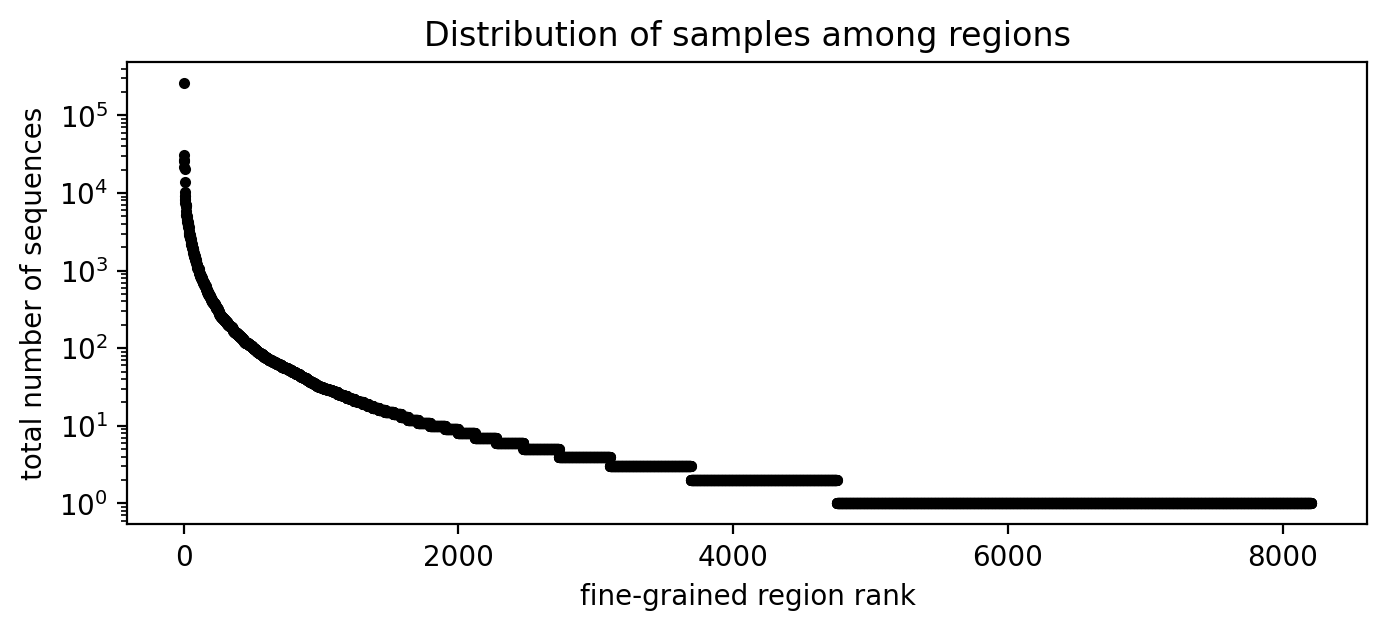

In [5]:
plt.figure(figsize=(8, 3))
plt.plot([count for _, count in Counter(locations).most_common()], "k.")
plt.yscale("log")
plt.xlabel("fine-grained region rank")
plt.ylabel("total number of sequences")
plt.title("Distribution of samples among regions");

In [6]:
aa_features = torch.load("results/nextclade.features.pt")
print(aa_features.keys())

dict_keys(['lineages', 'mutations', 'features'])


In [7]:
print(aa_features["features"].shape)

torch.Size([1245, 13366])


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

In [8]:
us_cases_df = read_csv("time_series_covid19_confirmed_US.csv")
global_cases_df = read_csv("time_series_covid19_confirmed_global.csv")
case_data = torch.cat([
    pd_to_torch(us_cases_df, columns=slice(11, None)),
    pd_to_torch(global_cases_df, columns=slice(4, None)),
]).T
sample_region, sample_matrix, region_tuples = gisaid_to_jhu_location(
    columns, us_cases_df, global_cases_df
)
num_gisaid_regions, num_jhu_regions = sample_matrix.shape

In [9]:
print(case_data.shape)
print(sample_region.shape)
print(sample_matrix.shape)
print(len(set(columns['location'])))
print(len(columns['location']))

torch.Size([429, 3614])
torch.Size([873343])
torch.Size([8209, 3614])
8209
873343


## Aggregating regions

We'll aggregate locations by either US state, UK regions, or other country.

In [10]:
TIMESTEP = 14  # Reasonable values might be week, fortnight, or month.
features = aa_features["features"]
lineages = [pangolin.compress(x) for x in columns["lineage"]]
lineage_id_inv = [pangolin.compress(x) for x in aa_features["lineages"]]
lineage_id = {k: i for i, k in enumerate(lineage_id_inv)}

In [11]:
sparse_data = Counter()
location_id = OrderedDict()
quotient = OrderedDict()
for day, location, lineage in zip(columns["day"], columns["location"], lineages):
    if lineage not in lineage_id:
        print(f"WARNING skipping unsampled lineage {lineage}")
        continue
    parts = location.split("/")
    if len(parts) < 2:
        continue
    parts = [p.strip() for p in parts[:3]]
    if parts[1] not in ("USA", "United Kingdom"):
        parts = parts[:2]
    quotient[location] = " / ".join(parts)
    p = location_id.setdefault(quotient[location], len(location_id))
    s = lineage_id[lineage]
    t = day // TIMESTEP
    sparse_data[t, p, s] += 1

WARNING skipping unsampled lineage B.1.351.1


In [12]:
T = 1 + max(columns["day"]) // TIMESTEP
P = len(location_id)
S = len(lineage_id)
weekly_strains = torch.zeros(T, P, S)
for (t, p, s), n in sparse_data.items():
    weekly_strains[t, p, s] = n
print(weekly_strains.shape, weekly_strains.shape.numel())

torch.Size([35, 248, 1245]) 10806600


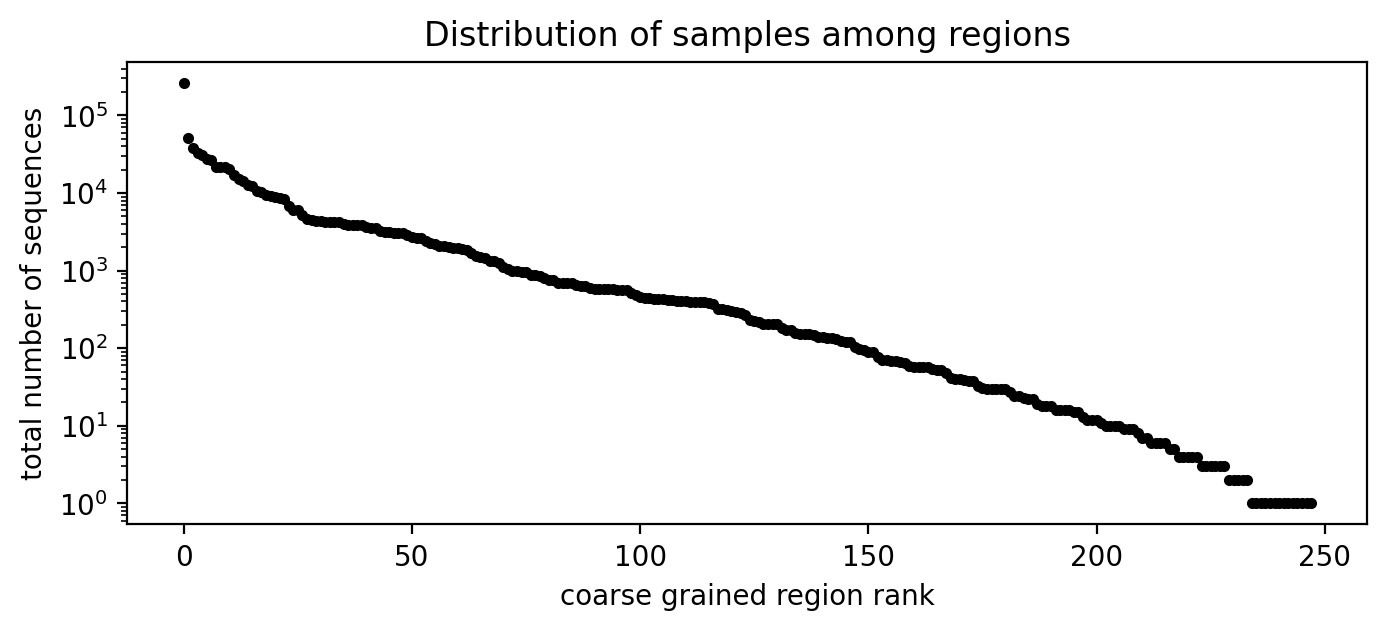

In [13]:
location_totals = weekly_strains.sum((0, 2)).sort(descending=True).values
plt.figure(figsize=(8, 3))
plt.plot(location_totals, "k.")
plt.yscale("log")
plt.xlabel("coarse grained region rank")
plt.ylabel("total number of sequences")
plt.title("Distribution of samples among regions");

In [14]:
quotient_matrix = torch.zeros(len(location_id), num_jhu_regions)
gisaid_id = {k: i for i, k in enumerate(sorted(quotient))}
for g, q in quotient.items():
    quotient_matrix[location_id[q]] += sample_matrix[gisaid_id[g]]
count_data = case_data @ quotient_matrix.T
count_data.shape

torch.Size([429, 248])

Convert from daily to weekly observations.

In [15]:
start_date = parse_date("12/01/19")
jhu_start_date = parse_date(us_cases_df.columns[11])
assert start_date < jhu_start_date
dt = (jhu_start_date - start_date).days
weekly_cases = torch.zeros(T, P)
for w in range(TIMESTEP):
    t0 = (w + dt) // TIMESTEP
    source = count_data[w::TIMESTEP]
    destin = weekly_cases[t0:t0+len(source)]
    destin[:] += source[:len(destin)]
assert weekly_cases.sum() > 0
print(weekly_cases.shape)

torch.Size([35, 248])


Heuristically estimate the number of infections. This need not be very accurate.

In [16]:
response_rate = 0.05
weekly_infections = torch.maximum(weekly_cases, weekly_strains.sum(-1)) / response_rate
weekly_infections.clamp_(min=1);

## Filtering out low-coverage regions and rare mutations

To avoid fitting highly uncertain parameters, we'll drop regions with no temporal diversity in sequencing

In [17]:
num_times_observed = (weekly_strains > 0).max(2).values.sum(0)
ok_regions = (num_times_observed >= 2).nonzero(as_tuple=True)[0]
ok_region_set = set(ok_regions.tolist())
print("Keeping {}/{} regions".format(len(ok_regions), weekly_strains.shape[1]))
filtered = {}
filtered["weekly_strains"] = weekly_strains.index_select(1, ok_regions)
filtered["weekly_infections"] = weekly_infections.index_select(1, ok_regions)
filtered["location_id"] = dict(zip([k for k, v in location_id.items() if v in ok_region_set],
                                   range(len(ok_regions))))

Keeping 224/248 regions


and drop mutations that are not dominant in at least one strain.

In [18]:
mutations = aa_features['mutations']
num_strains_with_mutation = (features >= 0.5).sum(0)
ok_mutations = (num_strains_with_mutation >= 1).nonzero(as_tuple=True)[0]
print("Keeping {}/{} mutations".format(len(ok_mutations), len(mutations)))
filtered["mutations"] = [mutations[i] for i in ok_mutations.tolist()]
filtered["features"] = features.index_select(1, ok_mutations)

Keeping 2209/13366 mutations


In [19]:
locals().update(filtered)

## Constructing a Pyro model

Our first model is a logistic growth model with a Dirichlet-multinomial likelihood (the multivariate generalization of negative binomial likelihood). This ignores any spatial structure across regions.

In [20]:
def model(weekly_strains, weekly_infections, features, feature_scale=None, noisy=False):
    assert weekly_strains.shape[-1] == features.shape[0]
    assert weekly_infections.shape == weekly_strains.shape[:2]
    T, P, S = weekly_strains.shape
    S, F = features.shape
    time_plate = pyro.plate("time", T, dim=-2)
    dtime_plate = pyro.plate("dtime", T - 1, dim=-2)
    place_plate = pyro.plate("place", P, dim=-1)
    time = torch.arange(float(T)) * TIMESTEP / 365.25  # in years
    time -= time.max()
    feature_scale = None if feature_scale is None else torch.as_tensor(feature_scale)

    # Assume relative growth rate depends on mutation features but not time or place.
    feature_scale = pyro.sample("feature_scale", dist.LogNormal(0, 1),
                                obs=feature_scale)
    log_rate_coef = pyro.sample(
        "log_rate_coef", dist.Laplace(0, feature_scale).expand([F]).to_event(1)
    )
    log_rate = pyro.deterministic("log_rate", log_rate_coef @ features.T)

    # Assume places differ only in their initial infection count.
    with place_plate:
        log_init = pyro.sample(
            "log_init", dist.Normal(0, 10).expand([S]).to_event(1)
        )
    logits = log_init + log_rate * time[:, None, None]

    # Optionally add process noise corresponding to epidemiological randomness.
    if noisy:
        # Noise depends on time, place, and strain, but with a shared scale.
        with time_plate, place_plate:
            rep = HaarReparam(dim=-3, experimental_allow_batch=True)
            # Sample noise from near uniform, encoding the prior as a factor graph.
            with poutine.reparam(config={"noise": rep}), poutine.scale(scale=1/T):
                noise = pyro.sample(
                    "noise", dist.Normal(0, 1).expand([T, P, S]).to_event(1)
                )
        logits = logits + noise
    strain_probs = logits.softmax(-1)
    strain_counts = pyro.deterministic(
        "strain_counts", (weekly_infections[..., None] * strain_probs).clamp(min=1e-3)
    )
    
    if noisy:
        # This is moment-matched to Poisson noise as in a discrete-state Markov chain.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(0, 1))
        noise_scale = noise_scale * strain_counts[:-1].reciprocal().log1p().sqrt()
        with dtime_plate, place_plate:
            pyro.sample(
                "dynamics",
                dist.Normal(0, noise_scale).to_event(1),
                obs=noise[1:] - noise[:-1],
            )

    # Finally observe overdispersed counts.
    strain_probs = logits.softmax(-1) if strain_probs is None else strain_probs
    concentration = pyro.sample("concentration", dist.LogNormal(2, 4))
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.DirichletMultinomial(
                total_count=weekly_strains.sum(-1).max(),
                concentration=concentration * strain_probs,
                is_sparse=True,  # uses a faster algorithm
            ),
            obs=weekly_strains,
        )

## Fitting the model

We'll use simple MAP estimation via Pyro's SVI and an `AutoDelta` guide. I'm defining a custom initialization function to initialize forecasts to uniformly even rather than random.

In [21]:
def init_loc_fn(site):
    if site["name"] in ("log_rate_coef", "log_rate", "log_init", "noise", "noise_haar"):
        return torch.zeros(site["fn"].shape())
    if site["name"] == "feature_scale":
        return torch.ones(site["fn"].shape())
    if site["name"].endswith("noise_scale"):
        return torch.full(site["fn"].shape(), 3.0)
    if site["name"] == "concentration":
        return torch.full(site["fn"].shape(), 5.0)
    return init_to_median(site)

First let's train a simple linear-logistic model with no process noise.

Training guide with 281090 parameters:
step    0 loss = 26.7	conc. = 5.26	noise. = 0	
step   10 loss = 25.7	conc. = 6.65	noise. = 0	
step   20 loss = 25	conc. = 6.99	noise. = 0	
step   30 loss = 24.6	conc. = 7.96	noise. = 0	
step   40 loss = 24.2	conc. = 8.98	noise. = 0	
step   50 loss = 24	conc. = 10.3	noise. = 0	
step   60 loss = 23.9	conc. = 11.4	noise. = 0	
step   70 loss = 23.8	conc. = 12.6	noise. = 0	
step   80 loss = 23.7	conc. = 13.8	noise. = 0	
step   90 loss = 23.6	conc. = 15.3	noise. = 0	
step  100 loss = 23.6	conc. = 17.2	noise. = 0	
step  110 loss = 23.5	conc. = 19	noise. = 0	
step  120 loss = 23.5	conc. = 20.6	noise. = 0	
step  130 loss = 23.4	conc. = 22.8	noise. = 0	
step  140 loss = 23.4	conc. = 25	noise. = 0	
step  150 loss = 23.3	conc. = 26.9	noise. = 0	
step  160 loss = 23.3	conc. = 28.4	noise. = 0	
step  170 loss = 23.3	conc. = 29.7	noise. = 0	
step  180 loss = 23.3	conc. = 30.9	noise. = 0	
step  190 loss = 23.3	conc. = 32.5	noise. = 0	
step  200 loss = 23.2	conc. =

Text(0, 0.5, 'loss')

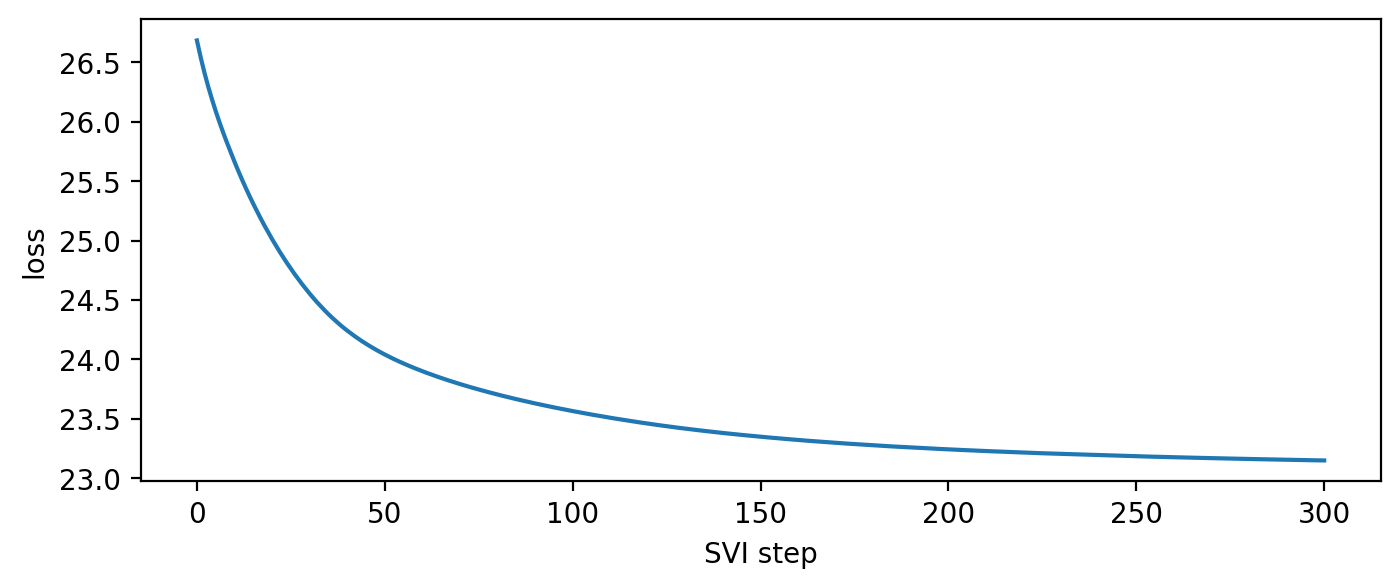

In [22]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(20210309)

guide = AutoDelta(model, init_loc_fn=init_loc_fn)
# Initialize guide so we can count parameters.
guide(weekly_strains, weekly_infections, features, feature_scale=1.0)
print("Training guide with {} parameters:".format(sum(p.numel() for p in guide.parameters())))
optim = ClippedAdam({"lr": 0.05, "betas": (0.8, 0.99)})
svi = SVI(model, guide, optim, Trace_ELBO())
losses = []
num_obs = weekly_strains.count_nonzero()
for step in range(301):
    loss = svi.step(weekly_strains, weekly_infections, features, feature_scale=1.0) / num_obs
    assert not math.isnan(loss)
    losses.append(loss)
    if step % 10 == 0:
        median = guide.median()
        concentration = median["concentration"].item()
        noise_scale = float(median.get("noise_scale", 0.0))
        print(f"step {step: >4d} loss = {loss:0.3g}\t"
              f"conc. = {concentration:0.3g}\t"
              f"noise. = {noise_scale:0.3g}\t")

plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss");

After fitting, we can extract a point estimate via the `guide.median()` method, which returns a dict.

In [23]:
map_median = guide.median()
map_median["log_rate"] = map_median["log_rate_coef"] @ features.T
print(", ".join(map_median.keys()))

log_rate_coef, log_init, concentration, log_rate


## Interpreting results

Since we're fitting relative growth rate and prevalence, we can characterize all lineages by these quantities. Note the relative transmissibility looks suspciously diverse, suggesting we should probably add process noise to our model.

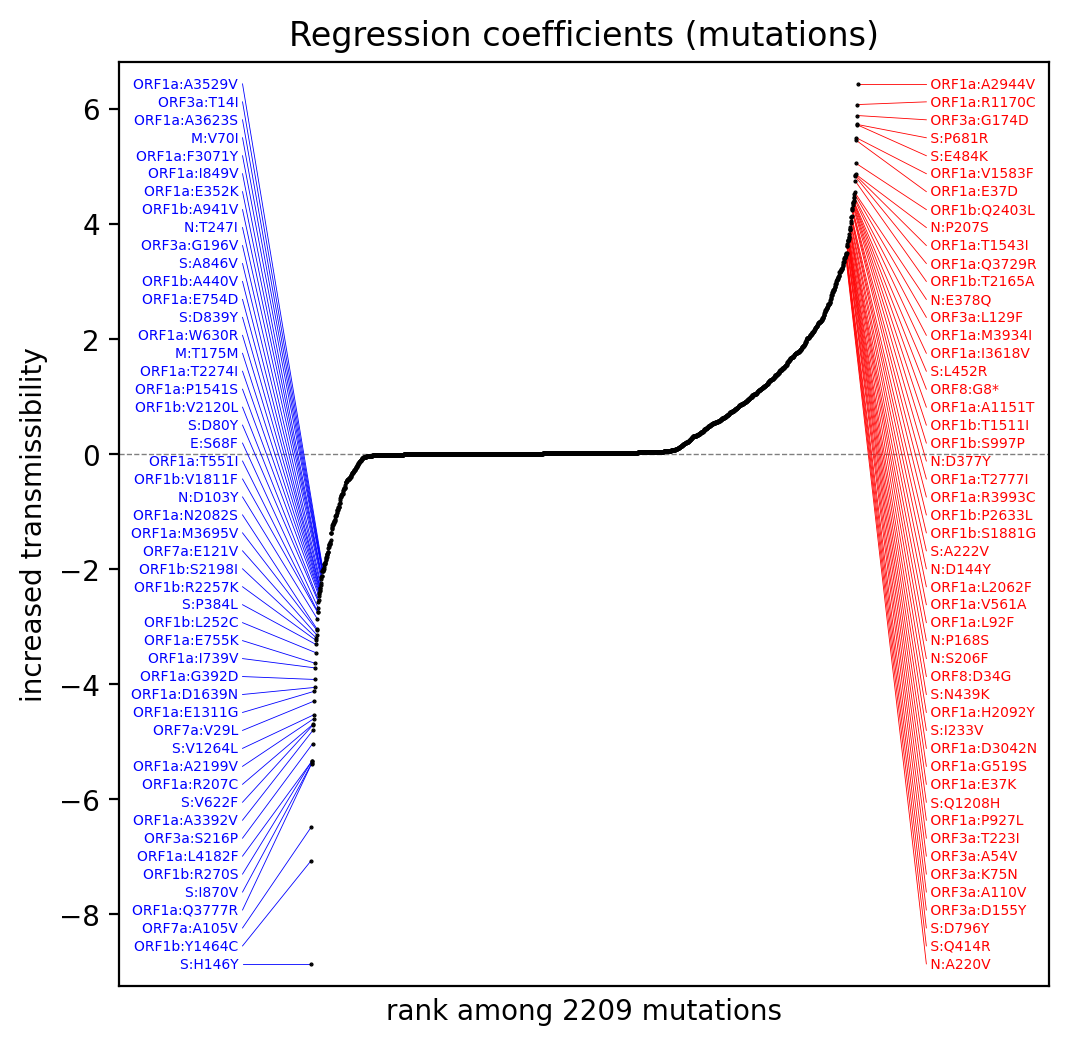

In [24]:
def plot_coefficients(median):
    xs, idx = median["log_rate_coef"].sort(0)
    assert len(idx) == len(mutations)
    plt.figure(figsize=(6, 6))
    plt.title("Regression coefficients (mutations)")
    plt.plot(xs, 'k.', lw=0, markersize=1, zorder=10)
    plt.axhline(0, color='black', lw=0.5, linestyle='--', alpha=0.5)
    plt.xlabel(f"rank among {len(xs)} mutations")
    plt.ylabel("increased transmissibility")

    I = len(idx)
    y0 = float(xs.min())
    y1 = float(xs.max())
    N = 50
    for i in range(N):
        x = -I / 8
        y = y0 + (y1 - y0) * i / (N - 1)
        plt.plot([i, x], [xs[i], y], color='blue', lw=0.3)
        plt.text(x, y, mutations[int(idx[i])] + " ", fontsize=5, color='blue',
                 verticalalignment="center", horizontalalignment="right")
    for i in range(I - N, I):
        x = I + I / 8
        y = y1 + (y0 - y1) * (I - i - 1) / (N - 1)
        plt.plot([i, x], [xs[i], y], color='red', lw=0.3)
        plt.text(x, y, " " + mutations[int(idx[i])], fontsize=5, color='red',
                 verticalalignment="center", horizontalalignment="left")
    plt.ylim(y0 - (y1 - y0) / 40, y1 + (y1 - y0) / 40)
    plt.xlim(-0.35 * I, 1.35 * I)
    plt.xticks(())

plot_coefficients(map_median)

We can also examine coefficients of some known mutations.

In [25]:
for name in ["N501Y", "D614G"]:
    i, = [i for i, m in enumerate(mutations) if name in m]
    coef = float(map_median["log_rate_coef"][i])
    print(f"{name} increases transmissibility by {coef:0.3g}")

N501Y increases transmissibility by 0.442
D614G increases transmissibility by 0.53


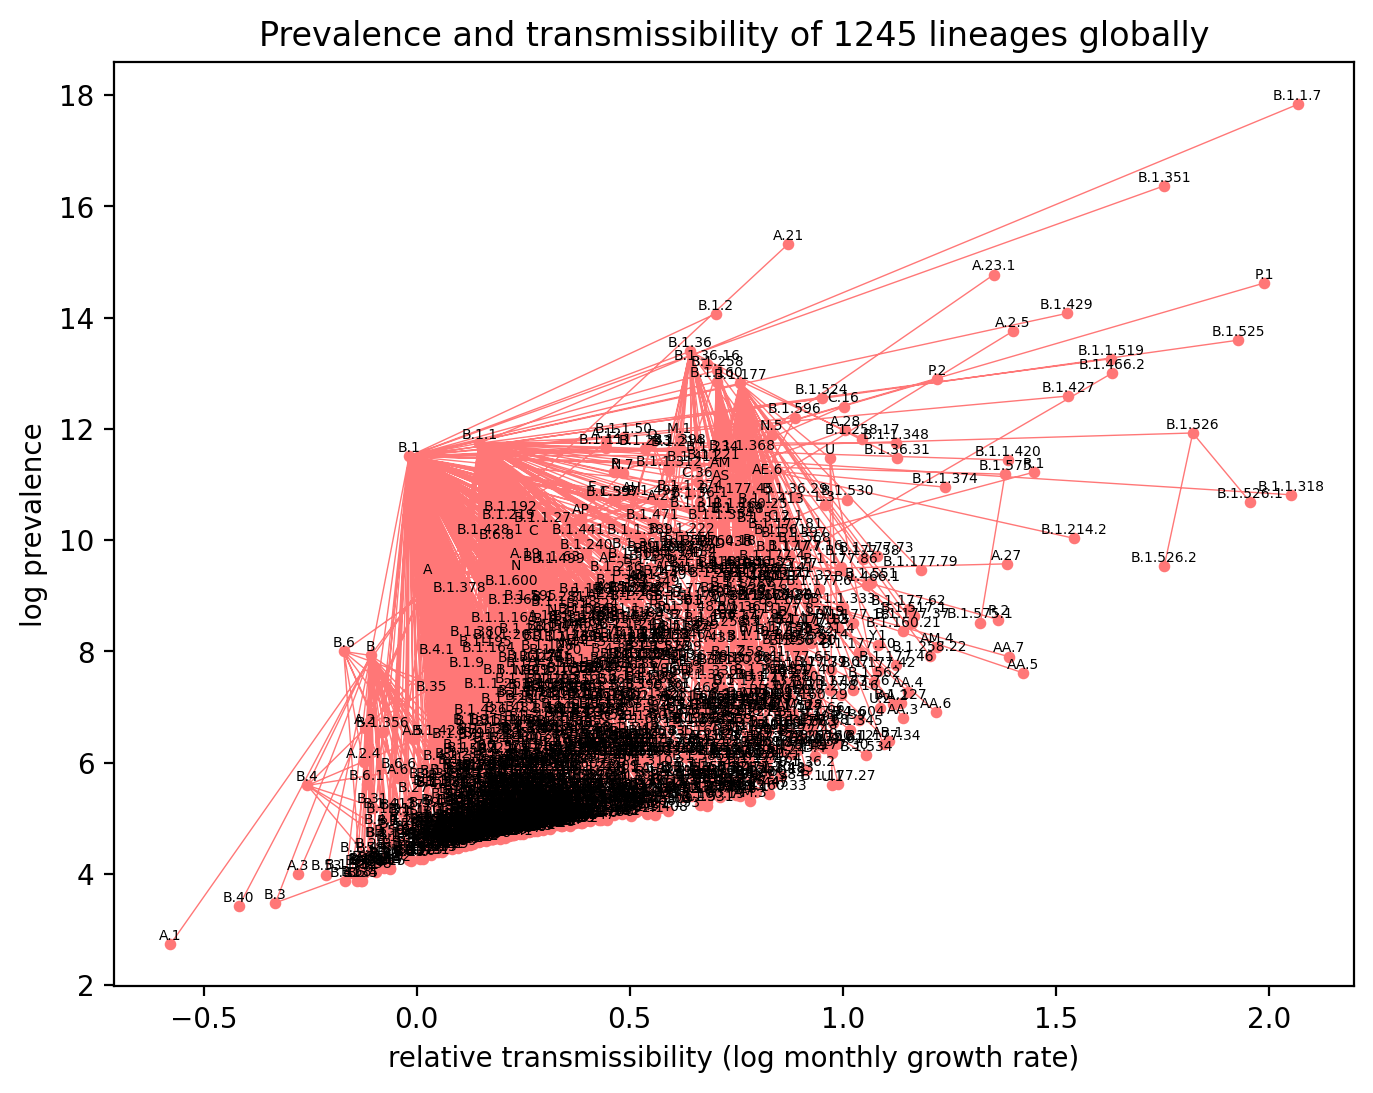

In [26]:
edges = pangolin.find_edges(list(lineage_id))
edges = torch.tensor([[lineage_id[u], lineage_id[v]] for u, v in edges], dtype=torch.long)

def plot_prevalence(place_query="", max_len=999):
    ids = [i for name, i in location_id.items() if place_query in name]
    local_lineages = weekly_strains.sum(0)[ids].sum(0).nonzero(as_tuple=True)[0]
    assert ids, "no locations matching " + place_query
    log_rate = map_median["log_rate"] / 12
    log_init = map_median["log_init"][ids].logsumexp(0)
    plt.figure(figsize=(8, 6))
    plt.scatter(log_rate[local_lineages], log_init[local_lineages], s=10, color="#ff7777")
    X, Y = [], []
    for u, v in edges.tolist():
        if u in local_lineages and v in local_lineages:
            X.extend([log_rate[u], log_rate[v], None])
            Y.extend([log_init[u], log_init[v], None])
    plt.plot(X, Y, color="#ff7777", lw=0.5)
    for name, i in lineage_id.items():
        plt.text(log_rate[i], log_init[i] + 0.08, name,
                 fontsize=5, horizontalalignment="center")
    plt.ylabel("log prevalence")
    plt.xlabel("relative transmissibility (log monthly growth rate)")
    plt.title(f"Prevalence and transmissibility of {len(local_lineages)} lineages"
              + (" in " + place_query if place_query else " globally"));
    
plot_prevalence(max_len=7)

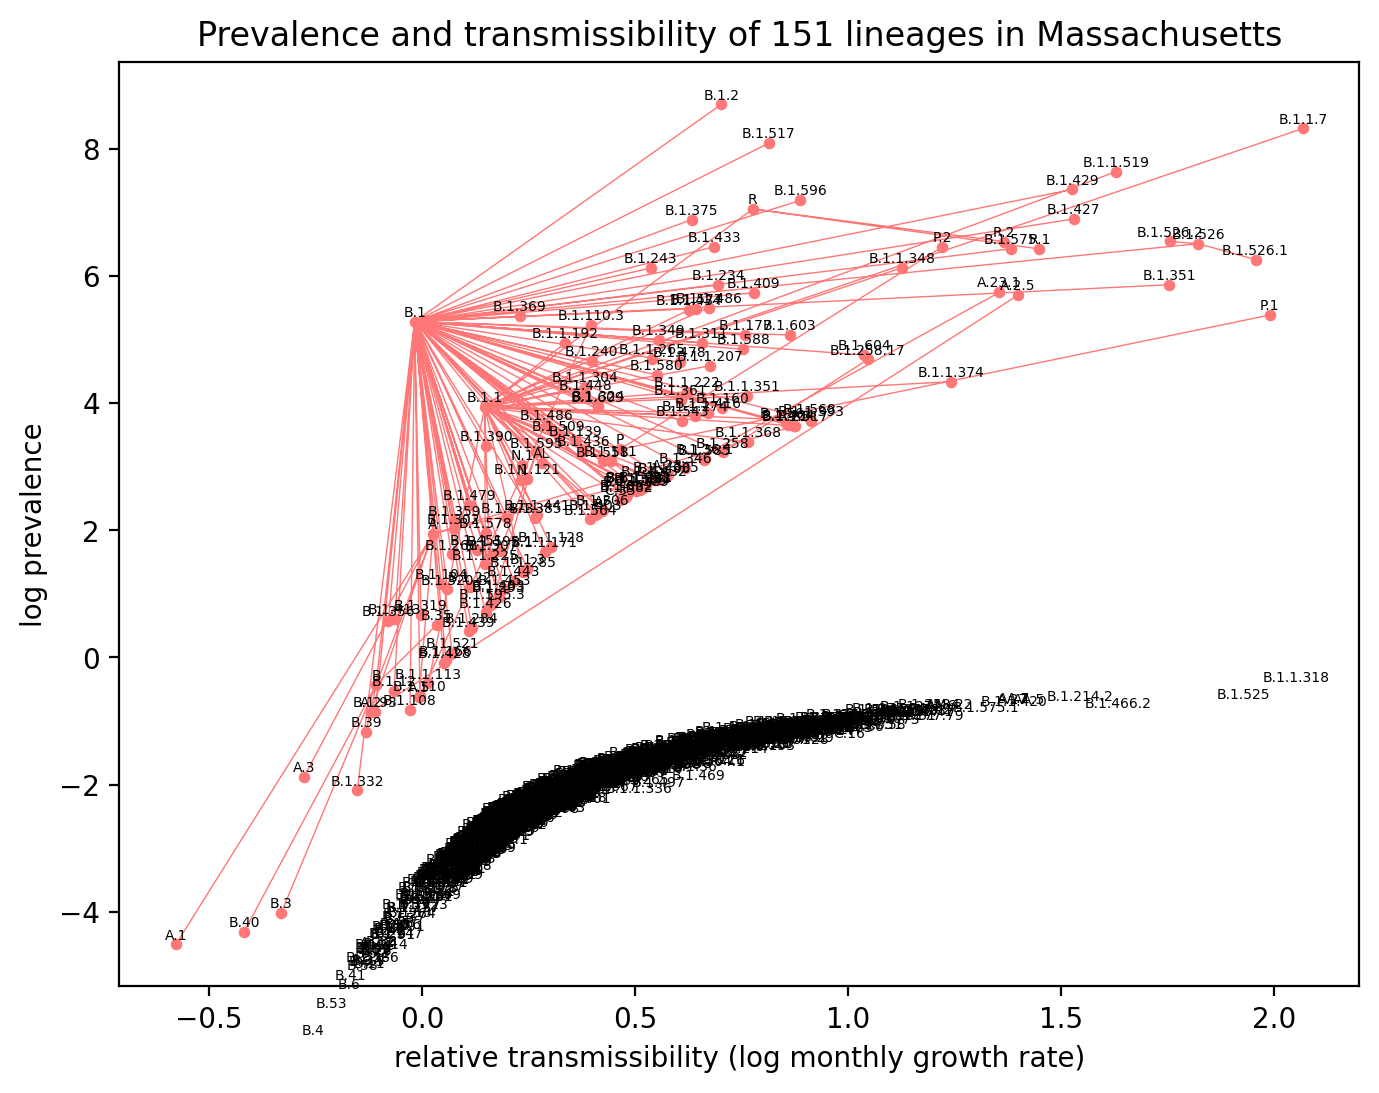

In [27]:
plot_prevalence("Massachusetts")

Finally we can use our logistic curves to forecast lineage prevalence in each region:

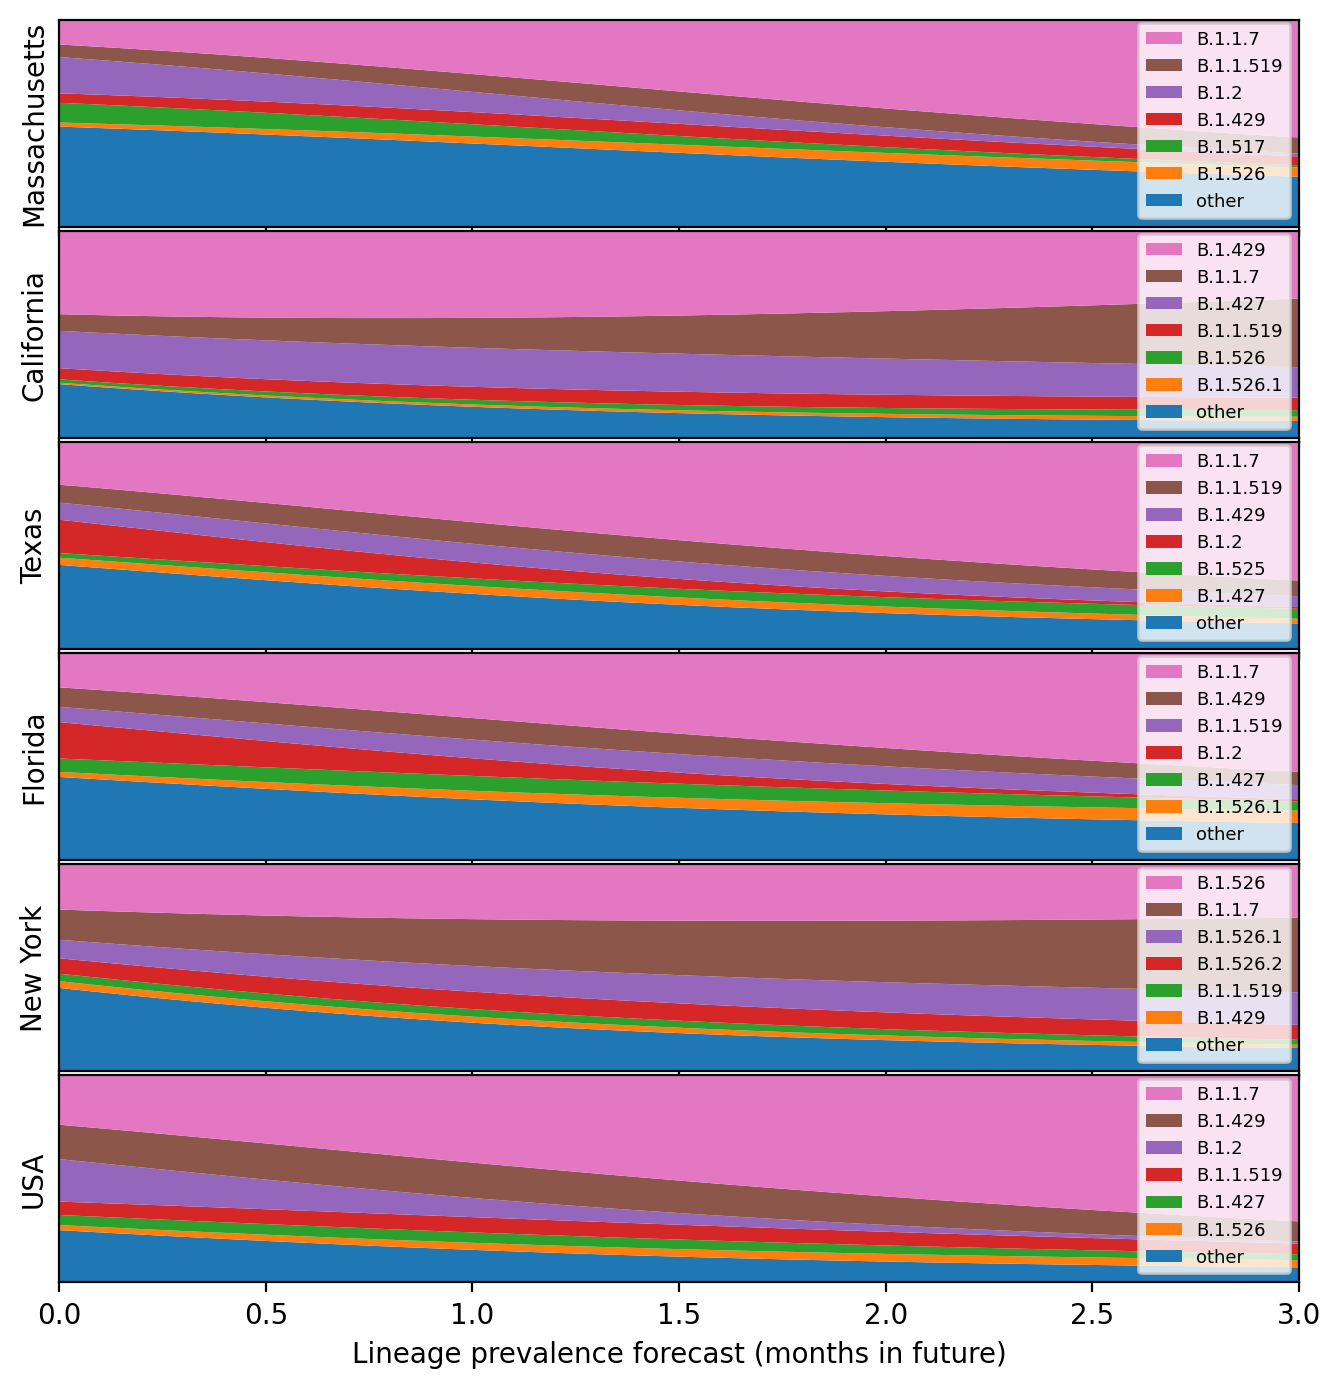

In [28]:
def plot_decomposition(queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        ids = [location_id[name] for name in names]
        assert ids, "no locations matching " + place_query
        log_rate = map_median["log_rate"]
        # FIXME this ignores region population when aggregating:
        log_init = map_median["log_init"][ids].logsumexp(0)
        assert log_init.shape == log_rate.shape
        time = torch.linspace(0, months_ahead / 12.0, 100)
        portion = (log_init + log_rate * time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(["Mass", "Calif", "Texas", "Florida", "New York", "USA"])

## Quantifying uncertainty

Next we'll upgrade from a point-estimating `AutoDelta` to a posterior distribution with learned uncertainty over a subset of latent variables.

Training guide with 283300 parameters:
step    0 loss = 26.8	conc. = 5.26	feat.scale = 0.951	
step   50 loss = 24.1	conc. = 9.95	feat.scale = 0.74	
step  100 loss = 23.6	conc. = 15.2	feat.scale = 0.847	
step  150 loss = 23.5	conc. = 21.7	feat.scale = 0.864	
step  200 loss = 23.3	conc. = 27.4	feat.scale = 0.868	
step  250 loss = 23.3	conc. = 30.7	feat.scale = 0.874	
step  300 loss = 23.3	conc. = 32.5	feat.scale = 0.872	
step  350 loss = 23.2	conc. = 33.7	feat.scale = 0.856	
step  400 loss = 23.2	conc. = 34.9	feat.scale = 0.854	
step  450 loss = 23.2	conc. = 34.9	feat.scale = 0.849	
step  500 loss = 23.2	conc. = 35.2	feat.scale = 0.841	
step  550 loss = 23.2	conc. = 36.1	feat.scale = 0.846	
step  600 loss = 23.2	conc. = 36.3	feat.scale = 0.845	
step  650 loss = 23.2	conc. = 36.2	feat.scale = 0.843	
step  700 loss = 23.2	conc. = 36.9	feat.scale = 0.84	
step  750 loss = 23.2	conc. = 36.8	feat.scale = 0.845	
step  800 loss = 23.2	conc. = 36.9	feat.scale = 0.844	
step  850 loss = 23.2	conc. 

Text(0, 0.5, 'loss')

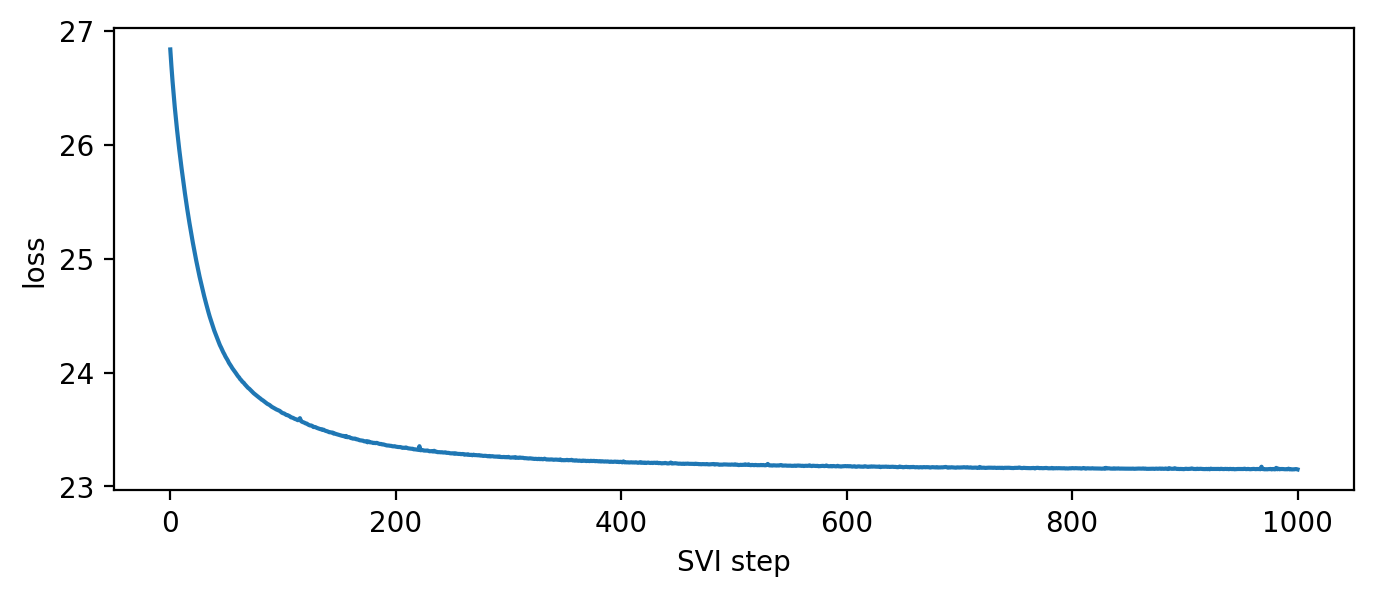

In [29]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(20210309)

guide = AutoGuideList(InitMessenger(init_loc_fn)(model))
guide.append(AutoDelta(poutine.block(model, hide=["log_rate_coef"]), init_loc_fn=init_loc_fn))
guide.append(AutoNormal(poutine.block(model, expose=["log_rate_coef"]),
                        init_loc_fn=init_loc_fn, init_scale=0.01))
# Initialize guide so we can count parameters.
guide(weekly_strains, weekly_infections, features)
print("Training guide with {} parameters:".format(sum(p.numel() for p in guide.parameters())))
num_steps = 1001
optim = ClippedAdam({"lr": 0.05, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, guide, optim, Trace_ELBO())
losses = []
num_obs = weekly_strains.count_nonzero()
for step in range(num_steps):
    loss = svi.step(weekly_strains, weekly_infections, features) / num_obs
    assert not math.isnan(loss)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        concentration = median["concentration"].item()
        feature_scale = median["feature_scale"].item()
        print(f"step {step: >4d} loss = {loss:0.3g}\t"
              f"conc. = {concentration:0.3g}\t"
              f"feat.scale = {feature_scale:0.3g}\t")

plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss");

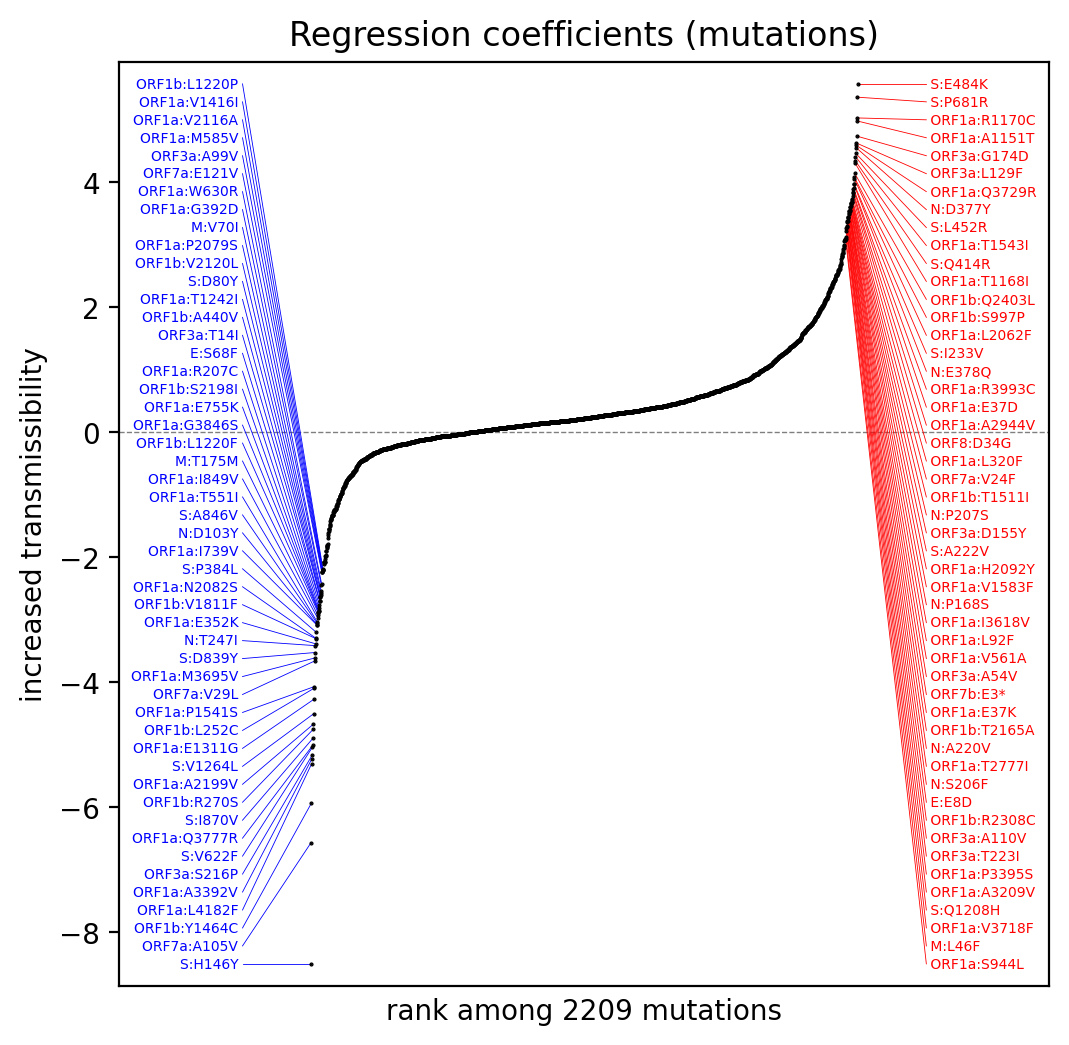

In [30]:
svi_median = guide.median()
svi_median["log_rate"] = svi_median["log_rate_coef"] @ features.T
plot_coefficients(svi_median)

In [31]:
guide.to(torch.double)
sigma_points = dist.Normal(0, 1).cdf(torch.tensor([-1., 1.])).double()
pos = guide[1].quantiles(sigma_points[1].item())
neg = guide[1].quantiles(sigma_points[0].item())
mean = {k: (pos[k] + neg[k]) / 2 for k in pos}
std = {k: (pos[k] - neg[k]) / 2 for k in pos}

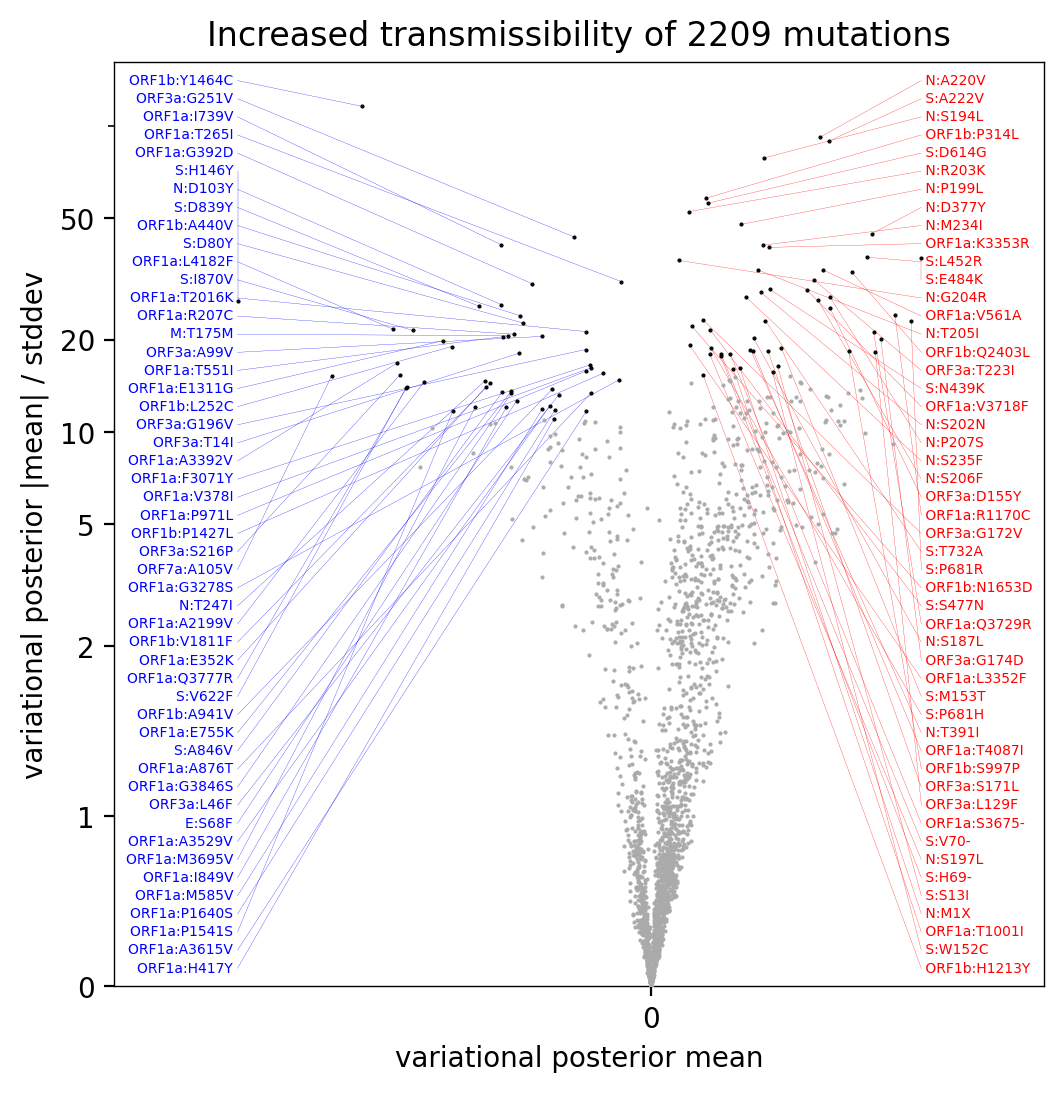

In [32]:
def plot_volcano(mean, std):
    mean = mean["log_rate_coef"]
    std = std["log_rate_coef"]
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = 50

    plt.figure(figsize=(6, 6))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=1, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=1, zorder=10, color="#aaa")
    plt.xlabel("variational posterior mean")
    # plt.ylabel("-log10 P(posterior mean has wrong sign)")
    plt.yscale("symlog")
    plt.ylabel("variational posterior |mean| / stddev")
    plt.xlim(x0 - (x1 - x0) * 0.18, x1 + (x1 - x0) * 0.18)
    plt.ylim(0, None)
    # plt.ylim(math.log(2) / math.log(10), None)
    plt.xticks((0,))
    yticks = (0, 1, 2, 5, 10, 20, 50)
    plt.yticks(yticks, list(map(str, yticks)))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x0
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='blue', lw=0.1)
        plt.text(x, y, mutations[int(idx_neg[i])] + " ", fontsize=5, color='blue',
                 verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='red', lw=0.1)
        plt.text(x, y, " " + mutations[int(idx_pos[i])], fontsize=5, color='red',
                 verticalalignment="center", horizontalalignment="left")

plot_volcano(mean, std)

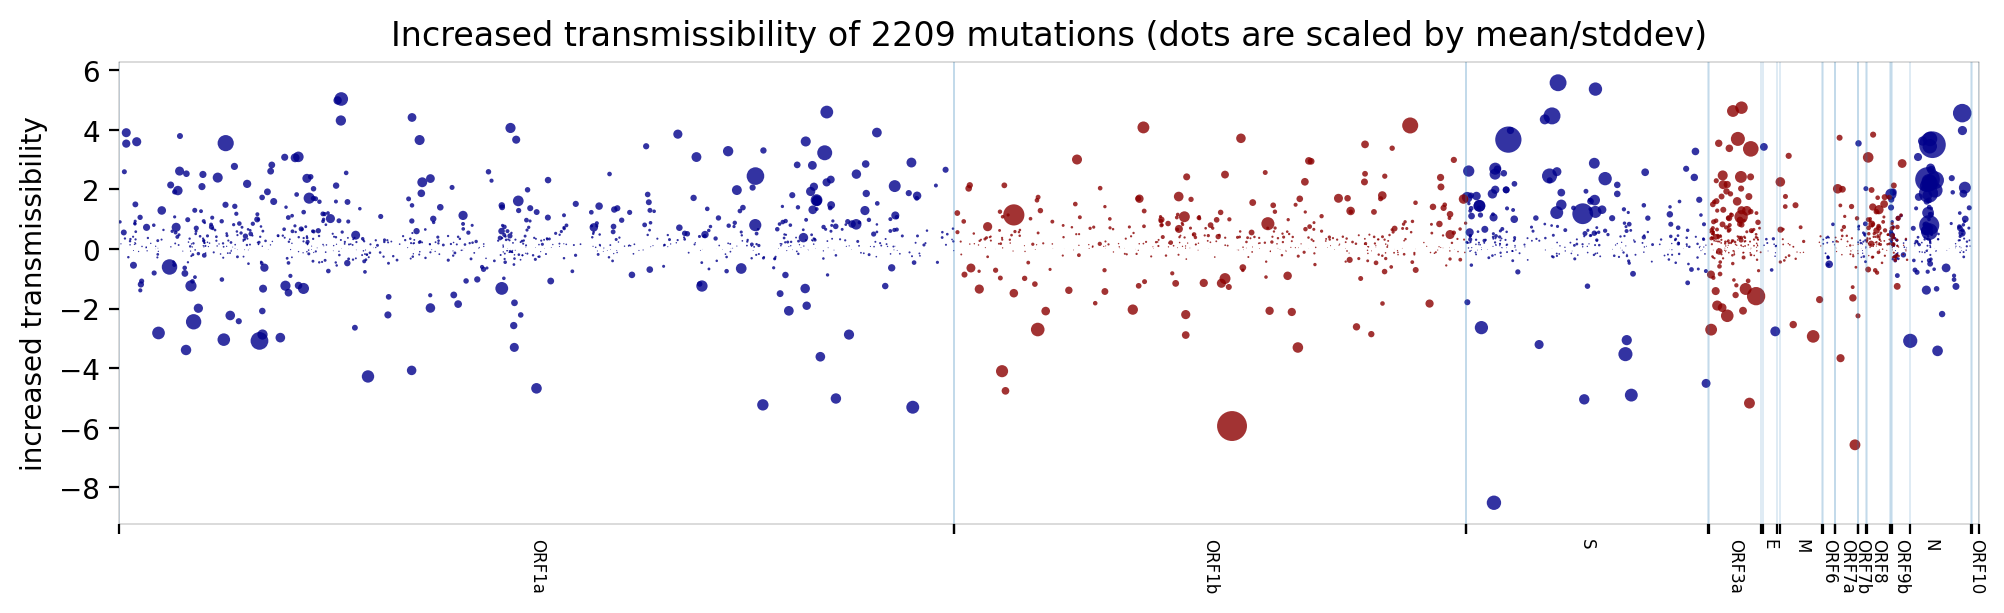

In [33]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, std):
    mean = mean["log_rate_coef"]
    std = std["log_rate_coef"]
    sigma = mean.abs() / std.clamp(min=1e-8)
    y0 = mean.min().item()
    y1 = mean.max().item()
    dy = y1 - y0
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0)

    plt.figure(figsize=(12, 3))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots are scaled by mean/stddev)")
    for mask, color in zip([even, ~even], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), mean[mask].numpy(), sigma[mask].numpy(),
                    color=color, alpha=0.8, lw=0)
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene_name, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene_name == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, y0 - dy / 12, gene_name, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("increased transmissibility")

plot_manhattan(mean, std)

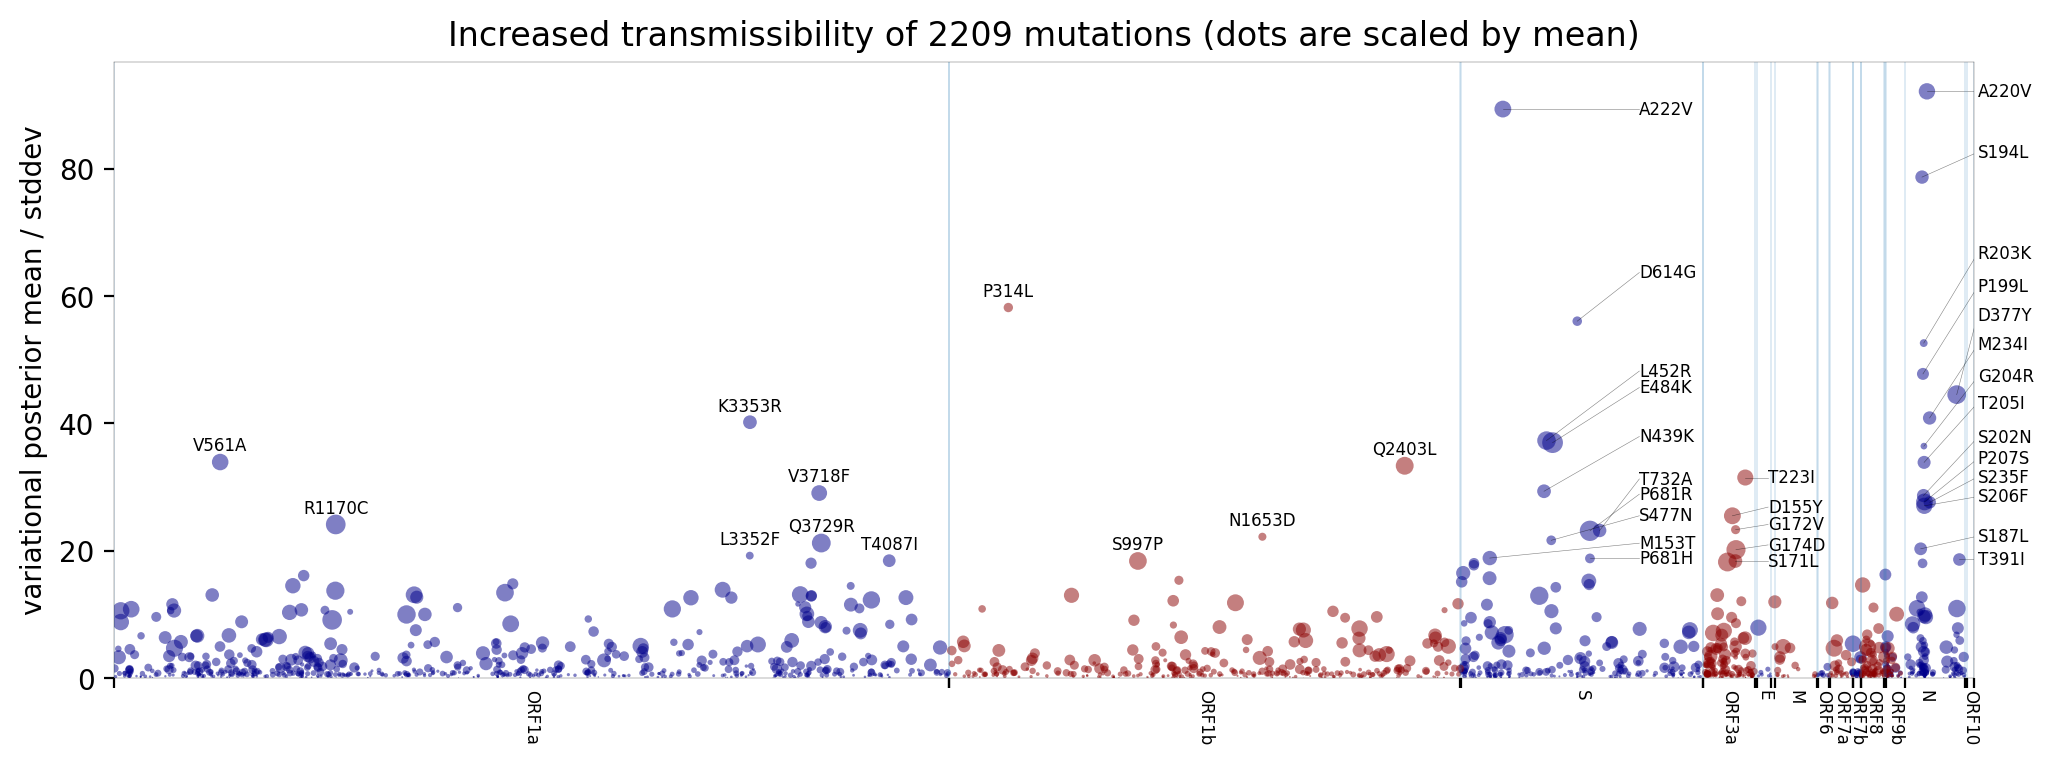

In [34]:
def plot_manhattan_pos(mean, std, top_k=40):
    mean = mean["log_rate_coef"]
    std = std["log_rate_coef"]
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(12, 4))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots are scaled by mean)")
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), sigma[mask].numpy(), 10 * mean[mask].numpy(),
                    color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items()}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        y_label = 0.7 * y + 0.3 * (ub + (lb - ub) * (i / (len(special["S"]) - 1)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in ["N", "ORF3a"]:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            y_label = 0.5 * y + 0.5 * (ub + (lb - ub) * (i / (len(special[gene]) - 1)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("variational posterior mean / stddev")

plot_manhattan_pos(mean, std)

## Extracting a table of top mutations and their stories

In [35]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [36]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [37]:
def write_table(mean, std, filename="paper/top_mutations.md", top_k=200):
    mean = mean["log_rate_coef"]
    std = std["log_rate_coef"]
    sigma = mean / std.clamp(min=1e-8)
    lineage_counts = weekly_strains.sum((0, 1))
    with open(filename, "wt") as f:
        f.write("This file was automatically generated by mutation_stochatic_model.ipynb\n")
        f.write("\n")
        f.write("| mutation | mean/stddev | mean | emerged in lineages |\n")
        f.write("| -------- | ----------- | ---- | ------------------- |\n")
        for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
            # top_lineage = lineages[(features[:, i] * lineage_counts).argmax(0).item()]
            emerged = find_emergences(i)
            f.write("| {} | {:0.3g} | {:0.3g} | {} |\n".format(
                mutations[i], sigma[i], mean[i], ", ".join(emerged)
            ))

write_table(mean, std)

In [38]:
def write_tsv(mean, std, filename="paper/top_mutations.tsv", top_k=200):
    mean = mean["log_rate_coef"]
    std = std["log_rate_coef"]
    sigma = mean / std.clamp(min=1e-8)
    lineage_counts = weekly_strains.sum((0, 1))
    with open(filename, "wt") as f:
        f.write("mutation\tmean/stddev\tmean\temerged in lineages\n")
        for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
            # top_lineage = lineages[(features[:, i] * lineage_counts).argmax(0).item()]
            emerged = find_emergences(i)
            f.write("{}\t{:0.6g}\t{:0.6g}\t{}\n".format(
                mutations[i], sigma[i], mean[i], ", ".join(emerged)
            ))

write_tsv(mean, std)